In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath(''))
sys.path.append(os.path.abspath('src/'))

# Import the environment and evaluation modules
from env_sailing import SailingEnv
from evaluation import evaluate_agent, visualize_trajectory
from sailing_physics import (
    generate_velocity_polar_plot, 
    generate_efficiency_curve,
    show_tacking_maneuver  # Add this import
)

# Import scenarios
from initial_windfields import get_initial_windfield, INITIAL_WINDFIELDS

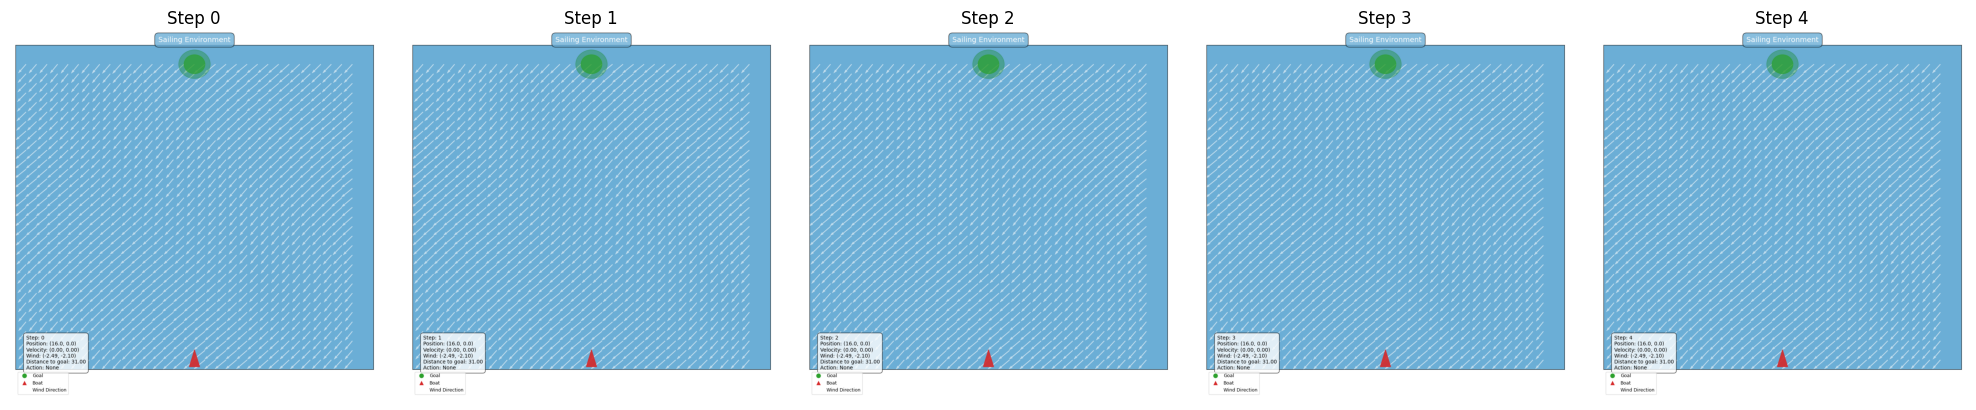

Notice how the wind pattern changes over time!
- Wind direction and strength evolve according to the common evolution parameters
- This evolution is the same for all training and test initial windfields
- Your agent must adapt to these changing conditions while navigating
- For debugging, you can use get_initial_windfield('simple_static') which has static wind


In [2]:
# Create an environment with the first training initial windfield
initial_windfield = get_initial_windfield("simple_static")
viz_params = {
    'env_params': {
        'wind_grid_density': 25,
        'wind_arrow_scale': 80,
        'render_mode': "rgb_array"
    }
}
initial_windfield.update(viz_params)

env = SailingEnv(
    wind_init_params=initial_windfield['wind_init_params'],
    wind_evol_params=initial_windfield['wind_evol_params'],
    wind_grid_density=25,
    wind_arrow_scale=80,
    render_mode="rgb_array"
)

# Reset the environment
env.reset(seed=42)

# Capture wind evolution over several steps
wind_frames = []
for step in range(5):  # Capture 5 frames
    # Render current state
    frame = env.render()
    wind_frames.append(frame)
    
    # Take a "stay in place" action to let wind evolve
    env.step(8)  # Action 8 is "stay in place"

# Display the frames
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, frame in enumerate(wind_frames):
    axes[i].imshow(frame)
    axes[i].set_title(f"Step {i}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print("Notice how the wind pattern changes over time!")
print("- Wind direction and strength evolve according to the common evolution parameters")
print("- This evolution is the same for all training and test initial windfields")
print("- Your agent must adapt to these changing conditions while navigating")
print("- For debugging, you can use get_initial_windfield('simple_static') which has static wind")

In [ ]:
import numpy as np
import heapq
from numba import njit

@njit
def calculate_new_velocity_numba(current_velocity, wind, direction, boat_performance, max_speed, inertia_factor):
    wind_norm = np.sqrt(wind[0]**2 + wind[1]**2)
    new_velocity = np.zeros(2, dtype=np.float32)
    wind_normalized = np.array([0.0, 0.0], dtype=np.float32)
    sailing_efficiency = 0.0

    if wind_norm > 0.0:
        wind_normalized = wind / wind_norm

        direction_norm = np.sqrt(direction[0]**2 + direction[1]**2)
        if direction_norm < 1e-10:
            direction_normalized = np.array([1.0, 0.0], dtype=np.float32)
        else:
            direction_normalized = direction / direction_norm

        dot = direction_normalized[0] * -wind_normalized[0] + direction_normalized[1] * -wind_normalized[1]
        angle = np.arccos(min(1.0, max(-1.0, dot)))

        if angle < np.pi / 4:
            sailing_efficiency = 0.05
        elif angle < np.pi / 2:
            sailing_efficiency = 0.5 + 0.5 * (angle - np.pi / 4) / (np.pi / 4)
        elif angle < 3 * np.pi / 4:
            sailing_efficiency = 1.0
        else:
            sailing_efficiency = max(0.5, 1.0 - 0.5 * (angle - 3 * np.pi / 4) / (np.pi / 4))

        theoretical_velocity = direction * sailing_efficiency * wind_norm * boat_performance
        speed = np.sqrt(theoretical_velocity[0]**2 + theoretical_velocity[1]**2)
        if speed > max_speed:
            theoretical_velocity = theoretical_velocity / speed * max_speed

        new_velocity = theoretical_velocity + inertia_factor * (current_velocity - theoretical_velocity)
        speed = np.sqrt(new_velocity[0]**2 + new_velocity[1]**2)
        if speed > max_speed:
            new_velocity = new_velocity / speed * max_speed
    else:
        new_velocity = inertia_factor * current_velocity

    return new_velocity.astype(np.float32), wind_normalized.astype(np.float32), sailing_efficiency



@njit
def get_neighbors_numba(pos, velocity, acc, wind_grid, grid_size, boat_performance, max_speed, inertia_factor):
    actions = np.array([
        [0, 1], [1, 1], [1, 0], [1, -1],
        [0, -1], [-1, -1], [-1, 0], [-1, 1], [0,0]
    ], dtype=np.int32)

    n_actions = actions.shape[0]
    neighbors = np.zeros((n_actions, 11), dtype=np.float32)  # increased to 11

    for i in range(n_actions):
        direction = np.array([float(actions[i, 0]), float(actions[i, 1])], dtype=np.float32)
        x = min(max(int(pos[0]), 0), grid_size[0]-1)
        y = min(max(int(pos[1]), 0), grid_size[1]-1)

        wind = wind_grid[y, x]
        new_velocity, wind_direction, sailing_efficiency = calculate_new_velocity_numba(
            velocity, wind, direction, boat_performance, max_speed, inertia_factor
        )
        new_acc = acc + new_velocity
        new_position_float = pos + new_acc
        new_position = np.round(new_position_float).astype(np.int32)
        new_acc2 = new_position_float - new_position.astype(np.float32)
        new_position = np.minimum(np.maximum(new_position, np.array([0, 0], dtype=np.int32)), grid_size - 1)

        neighbors[i, 0:2] = new_position.astype(np.float32)
        neighbors[i, 2:4] = new_velocity
        neighbors[i, 4:6] = new_acc2
        neighbors[i, 6:8] = direction
        neighbors[i, 8:10] = wind_direction
        neighbors[i, 10] = sailing_efficiency

    return neighbors

def sailing_a_star_env_action(env, start, goal, boat_performance=0.4, max_iterations=None):
    grid_size = env.grid_size
    max_speed = env.max_speed
    inertia_factor = env.inertia_factor
    wind_grid = env.wind_field.astype(np.float32)
    def heuristic(pos):
        # Chebyshev distance: minimum steps in 8 directions
        delta = np.abs(np.array(pos) - np.array(goal))
        return np.max(delta)

    open_set = []
    start_tuple = (int(start[0]), int(start[1]))
    start_velocity = np.array([env.velocity[0], env.velocity[1]], dtype=np.float32)
    start_acc = np.array([env.position_accumulator[0], env.position_accumulator[1]], dtype=np.float32)
    start_wind = wind_grid[start_tuple[1], start_tuple[0]]

    heapq.heappush(open_set, (
        heuristic(start_tuple),
        0,
        start_tuple,
        tuple(start_velocity.tolist()),
        tuple(start_acc.tolist()),
        [{'pos': start_tuple, 'velocity': start_velocity, 'direction': np.array([0.0, 0.0]), 'wind': start_wind, 'efficiency': 0.0}]
    ))

    visited = set()
    iterations = 0
    while open_set:
        if max_iterations is not None and iterations >= max_iterations:
            print("A* stopped: max_iterations reached")
            return None
        iterations += 1

        est_total, cost_so_far, current, velocity, acc, path = heapq.heappop(open_set)
        velocity = np.array(velocity, dtype=np.float32)
        acc = np.array(acc, dtype=np.float32)

        if np.linalg.norm(np.array(current) - np.array(goal)) < 1.0:
            return path
        
        visited.add((current, tuple(np.round(velocity)), tuple(np.round(acc))))
        neighbors = get_neighbors_numba(
            np.array(current, dtype=np.float32),
            velocity.astype(np.float32),
            acc.astype(np.float32),
            wind_grid,
            np.array(grid_size, dtype=np.int32),
            boat_performance,
            max_speed,
            inertia_factor
        )
        for i in range(neighbors.shape[0]):
            neighbor = tuple(neighbors[i, 0:2].astype(np.int32))
            nvel = neighbors[i, 2:4]
            nacc = neighbors[i, 4:6]
            direction = neighbors[i, 6:8]
            wind_direction = neighbors[i, 8:10]
            sailing_efficiency = float(neighbors[i, 10])
            state_id = (neighbor, tuple(np.round(nvel, 2)), tuple(np.round(nacc, 2)))

            if state_id in visited:
                continue

            heapq.heappush(open_set, (
                cost_so_far + 1.0 + heuristic(neighbor),
                cost_so_far + 1.0,
                neighbor,
                tuple(nvel.tolist()),
                tuple(nacc.tolist()),
                path + [{
                    'pos': neighbor,
                    'velocity': nvel,
                    'direction': direction,
                    'wind': wind_direction,
                    'efficiency': sailing_efficiency
                }]
            ))
            print(f"Adding neighbor: {neighbor}, \n "
                    f"Velocity: {nvel}, \n "
                    f"Direction: {direction}, \n "
                    f"Wind Dir: {wind_direction}, \n "
                    f"Efficiency: {sailing_efficiency:.2f}")

    return None

# Example usage:
observation, info = env.reset(seed=42)
start = env.position
goal = env.goal_position
path = sailing_a_star_env_action(env, start, goal)
print("A* Path:")
for step in path:
    print(f"Position: {step['pos']}, "
          f"Velocity: {step['velocity']}, "
          f"Direction: {step['direction']}, "
          f"Wind Dir: {step['wind']}, "
          f"Efficiency: {step['efficiency']:.2f}")


Adding neighbor: (np.int32(16), np.int32(1)), Velocity: [0.        0.5058258], Direction: [0. 1.], Wind Dir: [-0.76451623 -0.6446045 ], Efficiency: 0.55
Adding neighbor: (np.int32(16), np.int32(0)), Velocity: [0.04564852 0.04564852], Direction: [1. 1.], Wind Dir: [-0.76451623 -0.6446045 ], Efficiency: 0.05
Adding neighbor: (np.int32(16), np.int32(0)), Velocity: [0.04564852 0.        ], Direction: [1. 0.], Wind Dir: [-0.76451623 -0.6446045 ], Efficiency: 0.05
Adding neighbor: (np.int32(17), np.int32(0)), Velocity: [ 0.86362964 -0.86362964], Direction: [ 1. -1.], Wind Dir: [-0.76451623 -0.6446045 ], Efficiency: 0.95
Adding neighbor: (np.int32(16), np.int32(0)), Velocity: [ 0.        -0.9129703], Direction: [ 0. -1.], Wind Dir: [-0.76451623 -0.6446045 ], Efficiency: 1.00
Adding neighbor: (np.int32(15), np.int32(0)), Velocity: [-0.5058259 -0.5058259], Direction: [-1. -1.], Wind Dir: [-0.76451623 -0.6446045 ], Efficiency: 0.55
Adding neighbor: (np.int32(15), np.int32(0)), Velocity: [-0.8636

KeyboardInterrupt: 

In [ ]:
obs, reward, terminated, truncated, info = env.step(0)
action_map = {
    (0,1): 0,
    (1,1): 1,
    (1,0): 2,
    (1,-1): 3,
    (0,-1): 4,
    (-1,-1): 5,
    (-1,0): 6,
    (-1,1): 7,
    (0,0): 8
}

In [ ]:

position = info['position']
velocity = info['velocity']
print(f"Position: {position}, Velocity: {velocity}")
print(env.velocity)
print(env.position_accumulator)

Position: [16  1], Velocity: [0.         0.63308423]
[0.         0.63308423]
[ 0.         -0.36691577]


In [ ]:
start = env.position
print(f"Start position: {start}")
goal = env.goal_position
print(f"Goal position: {goal}")
print(f'current wind: {info["wind"]}')
path = sailing_a_star_env_action(env, start, goal)
print("A* Path:")
for step in path:
    print(f"Position: {step['pos']}, "
          f"Velocity: {step['velocity']}, "
          f"Direction: {step['direction']}, "
          f"Wind Dir: {step['wind']}, "
          f"Efficiency: {step['efficiency']:.2f}")

Start position: [16  1]
Goal position: [16 31]
current wind: [-2.2791611   0.08424654]
A* Path:
Position: (16, 1), Velocity: [0.         0.63308424], Direction: [0. 0.], Wind Dir: [-3.2198803  -0.02405496], Efficiency: 0.00
Position: (np.int32(16), np.int32(2)), Velocity: [0.       1.087229], Direction: [0. 1.], Wind Dir: [-0.9999721  -0.00747055], Efficiency: 1.00
Position: (np.int32(16), np.int32(3)), Velocity: [0.        1.1882814], Direction: [0. 1.], Wind Dir: [-0.99885005 -0.04794344], Efficiency: 0.97
Position: (np.int32(16), np.int32(4)), Velocity: [0.        1.1741457], Direction: [0. 1.], Wind Dir: [-0.9946991  -0.10282803], Efficiency: 0.93
Position: (np.int32(16), np.int32(5)), Velocity: [0.        1.1127748], Direction: [0. 1.], Wind Dir: [-0.98369336 -0.1798537 ], Efficiency: 0.88
Position: (np.int32(16), np.int32(6)), Velocity: [0.        1.0539209], Direction: [0. 1.], Wind Dir: [-0.9738289  -0.22728246], Efficiency: 0.85
Position: (np.int32(16), np.int32(7)), Velocity:

In [ ]:
# import cProfile
# cProfile.run('sailing_a_star_env_action(env, start, goal)')


In [5]:
def plot_a_star_arrows(frame, path, observation):
    """
    Plot the A* path as arrows showing direction and speed at each step,
    with intermediary positions colored in a gradient.
    """
    import matplotlib.cm as cm

    grid_size = env.grid_size
    wind_field_flat = observation[6:]
    wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
    X, Y = np.meshgrid(np.arange(grid_size[0]), np.arange(grid_size[1]))
    U = wind_grid[:, :, 0].T
    V = wind_grid[:, :, 1].T

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xlim(0, grid_size[0])
    ax.set_ylim(0, grid_size[1])
    ax.set_title("A* Path: Boat Direction and Speed (Gradient)")

    ax.quiver(X, Y, U, V, color='blue', alpha=0.3)
    start = path[0]['pos']
    goal = env.goal_position
    ax.plot(start[0]+0.5, start[1]+0.5, 'go', markersize=10, label="Start")
    ax.plot(goal[0]+0.5, goal[1]+0.5, 'ro', markersize=10, label="Goal")

    # Gradient colors for intermediary positions
    n = len(path)
    cmap = cm.get_cmap('viridis')
    for i, step in enumerate(path):
        pos = np.asarray(step['pos'])
        velocity = np.asarray(step['velocity'])
        color = cmap(i / (n-1)) if n > 1 else 'black'
        # Draw intermediary position
        ax.plot(pos[0]+0.5, pos[1]+0.5, marker='o', color=color, markersize=6, alpha=0.8)
        # Draw velocity arrow if nonzero
        if np.linalg.norm(velocity) > 1e-3:
            ax.arrow(
                pos[0]+0.5, pos[1]+0.5,
                velocity[0], velocity[1],
                color=color, width=0.05, head_width=0.5, length_includes_head=True, alpha=0.7
            )

    ax.legend()
    plt.show()

# Usage:
frame= env.render()
if path:
    plot_a_star_arrows(frame, path, observation)
else:
    print("No path found!")

NameError: name 'path' is not defined

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:05<08:52,  5.38s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 0: env.step + plotting took 0.0007 seconds


  2%|▏         | 2/100 [00:10<08:31,  5.22s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 1: env.step + plotting took 0.0007 seconds


  3%|▎         | 3/100 [00:16<08:46,  5.42s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 2: env.step + plotting took 0.0007 seconds


  4%|▍         | 4/100 [00:22<09:10,  5.74s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 3: env.step + plotting took 0.0008 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


/tmp/ipykernel_14992/117487906.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


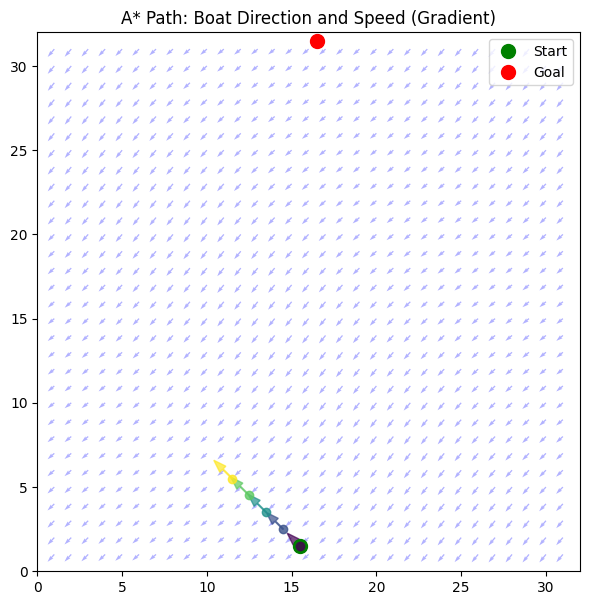

  5%|▌         | 5/100 [00:29<09:40,  6.11s/it]

Step 4: env.step + plotting took 0.8874 seconds


  6%|▌         | 6/100 [00:34<09:06,  5.81s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 5: env.step + plotting took 0.0008 seconds


  7%|▋         | 7/100 [00:39<08:45,  5.65s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 6: env.step + plotting took 0.0008 seconds


  8%|▊         | 8/100 [00:44<08:27,  5.52s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 7: env.step + plotting took 0.0009 seconds


  9%|▉         | 9/100 [00:51<08:40,  5.72s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 8: env.step + plotting took 0.0009 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


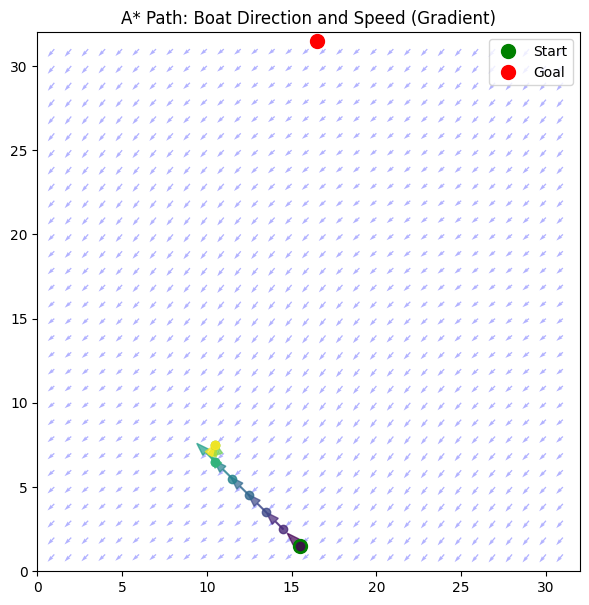

 10%|█         | 10/100 [00:58<09:19,  6.21s/it]

Step 9: env.step + plotting took 0.8997 seconds


 11%|█         | 11/100 [01:03<08:52,  5.99s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 10: env.step + plotting took 0.0010 seconds


 12%|█▏        | 12/100 [01:09<08:31,  5.81s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 11: env.step + plotting took 0.0009 seconds


 13%|█▎        | 13/100 [01:14<08:02,  5.55s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 12: env.step + plotting took 0.0007 seconds


 14%|█▍        | 14/100 [01:19<07:57,  5.55s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 13: env.step + plotting took 0.0007 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


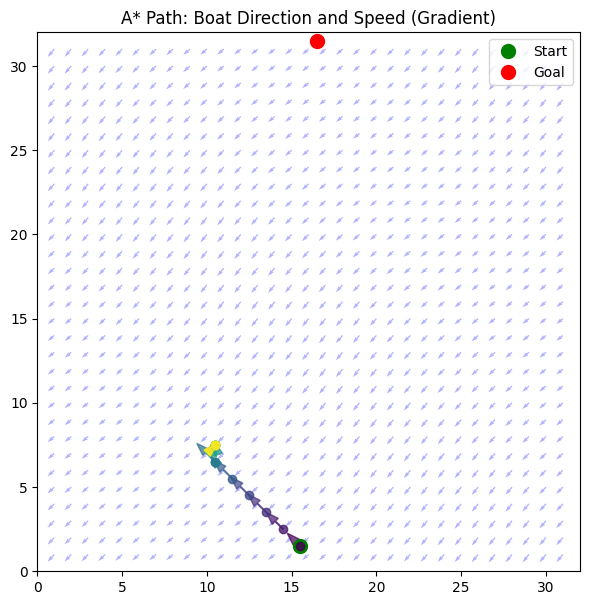

 15%|█▌        | 15/100 [01:25<08:03,  5.69s/it]

Step 14: env.step + plotting took 0.8588 seconds


 16%|█▌        | 16/100 [01:30<07:37,  5.44s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 15: env.step + plotting took 0.0008 seconds


 17%|█▋        | 17/100 [01:35<07:21,  5.32s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 16: env.step + plotting took 0.0007 seconds


 18%|█▊        | 18/100 [01:41<07:18,  5.35s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 17: env.step + plotting took 0.0008 seconds


 19%|█▉        | 19/100 [01:46<07:03,  5.23s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 18: env.step + plotting took 0.0009 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


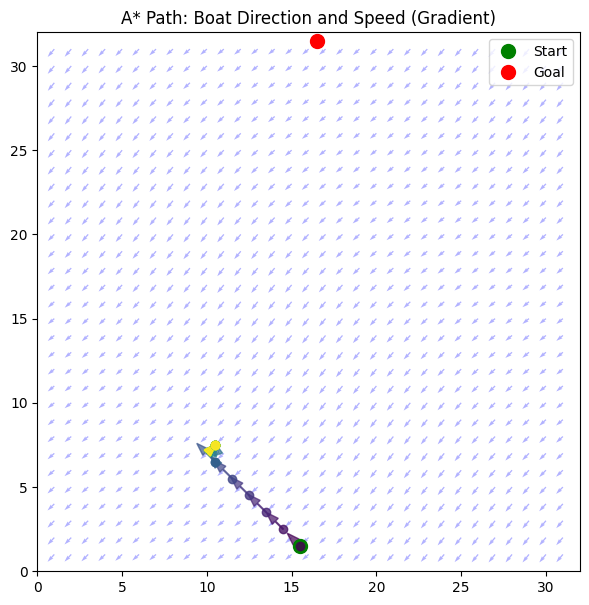

 20%|██        | 20/100 [01:51<07:11,  5.40s/it]

Step 19: env.step + plotting took 0.8847 seconds


 21%|██        | 21/100 [01:57<07:10,  5.45s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 20: env.step + plotting took 0.0009 seconds


 22%|██▏       | 22/100 [02:02<07:04,  5.44s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 21: env.step + plotting took 0.0011 seconds


 23%|██▎       | 23/100 [02:08<07:05,  5.53s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 22: env.step + plotting took 0.0011 seconds


 24%|██▍       | 24/100 [02:14<07:08,  5.64s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 23: env.step + plotting took 0.0010 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


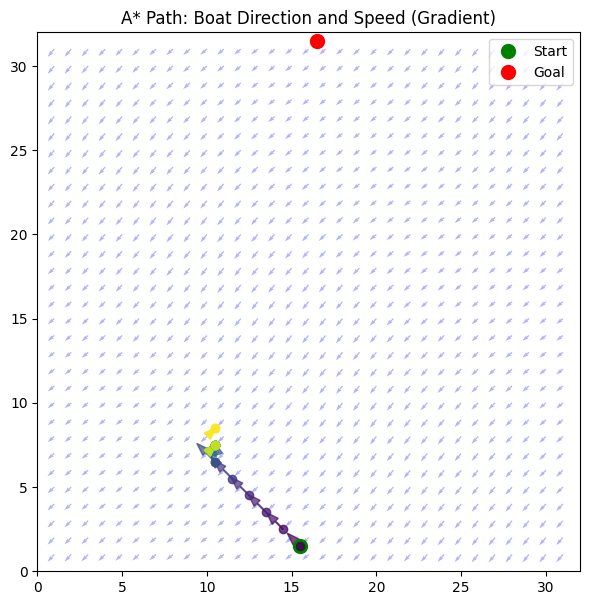

 25%|██▌       | 25/100 [02:21<07:36,  6.08s/it]

Step 24: env.step + plotting took 1.0912 seconds


 26%|██▌       | 26/100 [02:27<07:19,  5.94s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 25: env.step + plotting took 0.0007 seconds


 27%|██▋       | 27/100 [02:32<07:09,  5.89s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 26: env.step + plotting took 0.0009 seconds


 28%|██▊       | 28/100 [02:39<07:08,  5.95s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 27: env.step + plotting took 0.0008 seconds


 29%|██▉       | 29/100 [02:45<07:02,  5.95s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 28: env.step + plotting took 0.0013 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


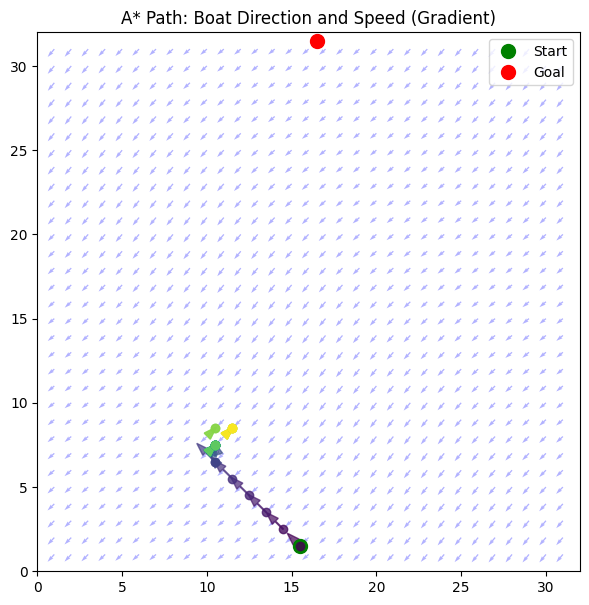

 30%|███       | 30/100 [02:52<07:21,  6.31s/it]

Step 29: env.step + plotting took 1.4245 seconds


 31%|███       | 31/100 [02:57<07:04,  6.15s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 30: env.step + plotting took 0.0011 seconds


 32%|███▏      | 32/100 [03:03<06:54,  6.09s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 31: env.step + plotting took 0.0019 seconds


 33%|███▎      | 33/100 [03:09<06:34,  5.89s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 32: env.step + plotting took 0.0009 seconds


 34%|███▍      | 34/100 [03:14<06:15,  5.69s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 33: env.step + plotting took 0.0008 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


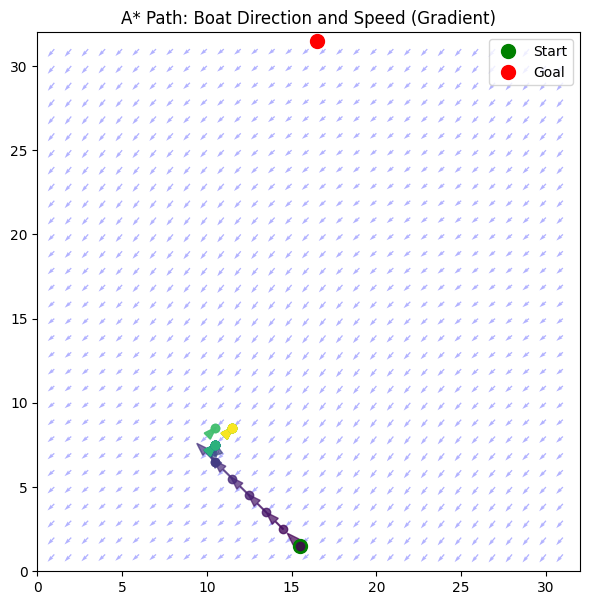

 35%|███▌      | 35/100 [03:20<06:22,  5.88s/it]

Step 34: env.step + plotting took 1.1858 seconds


 36%|███▌      | 36/100 [03:26<06:03,  5.69s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 35: env.step + plotting took 0.0010 seconds


 37%|███▋      | 37/100 [03:30<05:42,  5.44s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 36: env.step + plotting took 0.0009 seconds


 38%|███▊      | 38/100 [03:36<05:36,  5.43s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 37: env.step + plotting took 0.0008 seconds


 39%|███▉      | 39/100 [03:41<05:25,  5.34s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 38: env.step + plotting took 0.0008 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


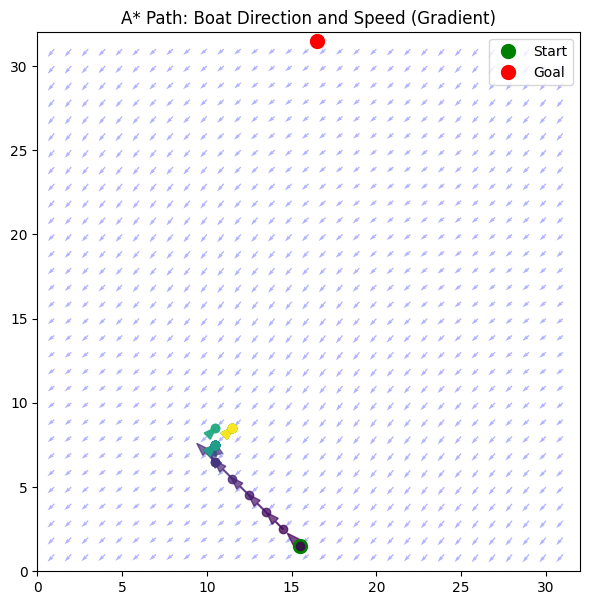

 40%|████      | 40/100 [03:48<05:43,  5.73s/it]

Step 39: env.step + plotting took 1.0206 seconds


 41%|████      | 41/100 [03:53<05:26,  5.54s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 40: env.step + plotting took 0.0009 seconds


 42%|████▏     | 42/100 [03:58<05:15,  5.45s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 41: env.step + plotting took 0.0013 seconds


 43%|████▎     | 43/100 [04:03<04:58,  5.23s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 42: env.step + plotting took 0.0011 seconds


 44%|████▍     | 44/100 [04:08<04:54,  5.25s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 43: env.step + plotting took 0.0008 seconds
A* stopped: max_iterations reached
A* failed or stopped, using greedy action


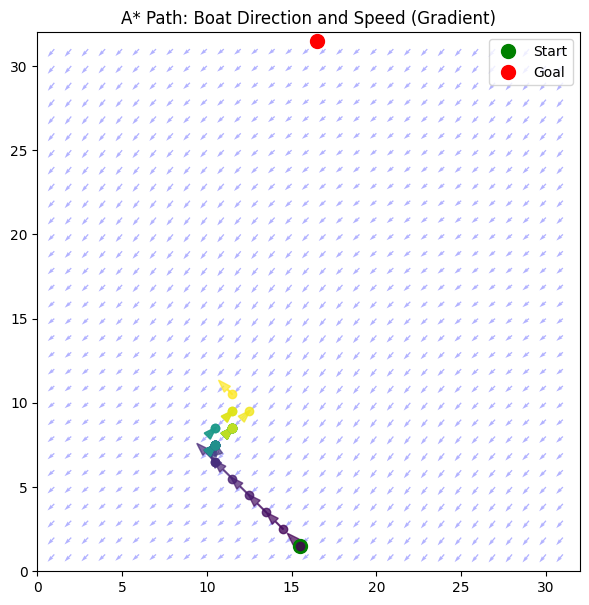

 45%|████▌     | 45/100 [04:14<05:05,  5.56s/it]

Step 44: env.step + plotting took 1.1198 seconds


 46%|████▌     | 46/100 [04:20<05:05,  5.66s/it]

A* stopped: max_iterations reached
A* failed or stopped, using greedy action
Step 45: env.step + plotting took 0.0008 seconds


KeyboardInterrupt: 

In [6]:
from tqdm import tqdm 
import matplotlib.cm as cm
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time 
from sailing_physics import calculate_sailing_efficiency

action_map = {
    (0,1): 0,
    (1,1): 1,
    (1,0): 2,
    (1,-1): 3,
    (0,-1): 4,
    (-1,-1): 5,
    (-1,0): 6,
    (-1,1): 7,
    (0,0): 8
}

def plot_greedy_a_star_evolution(env, steps=5, plot_stride=1, max_astar_iterations=6000):
    obs, info = env.reset()
    frames_obs = []
    paths_per_frame = []
    positions = [obs[:2].copy()]
    final_path = []
    for step in tqdm(range(steps)):
        # print(f"Step {step}, position: {obs[:2]}")
        frames_obs.append(obs.copy())
        wind_field_flat = obs[6:]
        wind_grid = wind_field_flat.reshape(env.grid_size[0], env.grid_size[1], 2)
        current_wind = wind_grid[int(obs[1]), int(obs[0])]
        # Run A* with max_iterations instead of timeout
        path = sailing_a_star_env_action(env, obs[:2], env.goal_position, max_iterations=max_astar_iterations)
        if path is not None and len(path) > 1:
            paths_per_frame.append(path)
            direction_of_next_pos = path[1]['direction']
            action = action_map[tuple(direction_of_next_pos)]
        else:
            print("A* failed or stopped, using greedy action")
            path = None
            paths_per_frame.append(None)
            #find closest direction from pos to goal
            direction_to_goal = env.goal_position - obs[:2]
            direction_to_goal = direction_to_goal / np.linalg.norm(direction_to_goal)
            #find the closest direction among the 8 possible actions using cos bins
            # Define possible directions
            directions = np.array([
                [0, 1], [1, 1], [1, 0], [1, -1],
                [0, -1], [-1, -1], [-1, 0], [-1, 1], [0, 0]
            ])

            # Compute dot products (cosine similarity)
            cosines = directions @ direction_to_goal
            efficiencies = [calculate_sailing_efficiency(direction / np.linalg.norm(direction) if np.linalg.norm(direction) > 1e-8 else direction, current_wind) for direction in directions]

            # Combine similarity and efficiency (tune weights as needed)
            scores = 0.7 * cosines + 0.3 * np.array(efficiencies)
            best_idx = np.argmax(scores)
            best_direction = tuple(directions[best_idx])
            action = action_map[best_direction]

        start_time = time.time()
        obs, reward, terminated, truncated, info = env.step(action)
        positions.append(obs[:2].copy())
        final_path.append({
            'pos': obs[:2].copy(),
            'velocity': obs[2:4].copy(),
        })
        if (step + 1) % plot_stride == 0 or terminated:
            # Plot the actual trajectory so far
            frame = env.render()
            plot_a_star_arrows(frame, final_path, obs)
        if terminated:
            break

        elapsed = time.time() - start_time
        print(f"Step {step}: env.step + plotting took {elapsed:.4f} seconds")
    # Display only every plot_stride-th frame with wind quiver and path arrows
    indices_to_plot = list(range(0, len(frames_obs), plot_stride))
    fig, axes = plt.subplots(1, len(indices_to_plot), figsize=(4*len(indices_to_plot), 6))
    if len(indices_to_plot) == 1:
        axes = [axes]
    for ax, i in zip(axes, indices_to_plot):
        observation = frames_obs[i]
        grid_size = env.grid_size
        wind_field_flat = observation[6:]
        wind_grid = wind_field_flat.reshape(grid_size[0], grid_size[1], 2)
        X, Y = np.meshgrid(np.arange(grid_size[0]), np.arange(grid_size[1]))
        U = wind_grid[:, :, 0].T
        V = wind_grid[:, :, 1].T
        ax.quiver(X, Y, U, V, color='blue', alpha=0.3)
        ax.set_xlim(0, grid_size[0])
        ax.set_ylim(0, grid_size[1])
        ax.set_title(f"Step {i}")
        ax.axis('off')
        # Overlay A* path arrows
        if paths_per_frame[i]:
            path = paths_per_frame[i]
            n = len(path)
            cmap = cm.get_cmap('viridis')
            for j, step in enumerate(path):
                pos = np.asarray(step['pos'])
                velocity = np.asarray(step['velocity'])
                color = cmap(j / (n-1)) if n > 1 else 'black'
                ax.plot(pos[0]+0.5, pos[1]+0.5, marker='o', color=color, markersize=6, alpha=0.8)
                if np.linalg.norm(velocity) > 1e-3:
                    ax.arrow(
                        pos[0]+0.5, pos[1]+0.5,
                        velocity[0], velocity[1],
                        color=color, width=0.05, head_width=0.5, length_includes_head=True, alpha=0.7
                    )
    plt.tight_layout()
    plt.show()

# Usage:
plot_greedy_a_star_evolution(env, steps=100, plot_stride=5)